<a href="https://colab.research.google.com/github/aaronjw-arch/gdp-dashboard/blob/main/ACDT%20G27%20code%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import chardet

file = "/content/ADO 2021_A1-GDP growth.csv"
# detect encoding
with open(file, 'rb') as f:
    raw = f.read(100000)
enc = chardet.detect(raw)
print(enc)

import pandas as pd
df = pd.read_csv(file, encoding='cp1252')
print(df.columns)
df.head()



{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}
Index(['RegionalMember', 'Year', 'GDP growth', 'Unit of Measurement',
       ' Subregion', ' Country Code'],
      dtype='object')


,RegionalMember,Year,GDP growth,Unit of Measurement,Subregion,Country Code
0,Afghanistan,2016,2.3,%,South Asia,AFG
1,Afghanistan,2017,2.6,%,South Asia,AFG
2,Afghanistan,2018,1.2,%,South Asia,AFG
3,Afghanistan,2019,3.9,%,South Asia,AFG
4,Afghanistan,2020,-5.0,%,South Asia,AFG


In [ ]:
import pandas as pd
import numpy as np
import glob, re, chardet

# ===============================================
# 1) Paths
# ===============================================
mys_path = "/content/Human Development Index - Full.csv"
gdp_files = glob.glob("/content/ADO*GDP*.csv")  # all your ADO GDP growth files

# ===============================================
# 2) Load and reshape MYS
# ===============================================
mys_raw = pd.read_csv(mys_path)
mys_raw.columns = mys_raw.columns.str.strip()

# Find columns like "Mean Years of Schooling (2019)"
mys_year_cols = [c for c in mys_raw.columns if c.lower().startswith("mean years of schooling")]
if not mys_year_cols:
    raise ValueError("❌ No 'Mean Years of Schooling (YYYY)' columns found. Check mys_raw.columns")

# Keep only ISO3, Country, and those MYS columns
keep_cols = ['ISO3', 'Country'] + mys_year_cols
mys = mys_raw[keep_cols].copy()

# Rename MYS columns to just the year number
rename_map = {}
for c in mys_year_cols:
    m = re.search(r'(\d{4})', c)
    if m:
        rename_map[c] = int(m.group(1))
mys = mys.rename(columns=rename_map)

# Melt to long format: Country | Year | MYS
mys_long = mys.melt(id_vars=['ISO3','Country'], var_name='Year', value_name='MYS')
mys_long['Year'] = pd.to_numeric(mys_long['Year'], errors='coerce')
mys_long = mys_long.dropna(subset=['Year','MYS'])

# Calculate year-to-year % change
mys_long = mys_long.sort_values(['Country','Year'])
mys_long['MYS_change'] = mys_long.groupby('Country')['MYS'].pct_change(fill_method=None) * 100

# ===============================================
# 3) Load GDP files (encoding fix)
# ===============================================
gdp_frames = []
for f in gdp_files:
    # detect encoding
    with open(f, 'rb') as raw:
        enc = chardet.detect(raw.read(50000))['encoding']
    df = pd.read_csv(f, encoding=enc)
    df.columns = df.columns.str.strip()
    # Select only needed columns: RegionalMember (country), Year, GDP growth
    if {'RegionalMember','Year','GDP growth'}.issubset(df.columns):
        df = df[['RegionalMember','Year','GDP growth']].rename(
            columns={'RegionalMember':'Country','GDP growth':'GDP_growth'}
        )
        gdp_frames.append(df)
    else:
        print(f"⚠️ Unexpected columns in {f}: {df.columns}")

gdp = pd.concat(gdp_frames, ignore_index=True)
gdp['Year'] = pd.to_numeric(gdp['Year'], errors='coerce')
gdp = gdp.dropna(subset=['Year','GDP_growth'])

# ===============================================
# 4) Filter MYS to only countries/years present in GDP
# ===============================================
gdp_keys = set(zip(gdp['Country'], gdp['Year']))
mys_filtered = mys_long[mys_long.apply(lambda r: (r['Country'], r['Year']) in gdp_keys, axis=1)]

# Merge
merged = pd.merge(mys_filtered, gdp, on=['Country','Year'], how='inner')
merged = merged.dropna(subset=['MYS_change','GDP_growth'])

# ===============================================
# 5) Save merged CSV
# ===============================================
output = "/content/MYSchange_GDPgrowth_ADOonly.csv"
merged.to_csv(output, index=False)

print(f"✅ Saved merged dataset: {output}")
print(merged.head())


✅ Saved merged dataset: /content/MYSchange_GDPgrowth_ADOonly.csv
  ISO3      Country  Year       MYS  MYS_change  GDP_growth
0  AFG  Afghanistan  2016  2.463660  -18.295923         2.2
1  AFG  Afghanistan  2016  2.463660  -18.295923         2.3
2  AFG  Afghanistan  2016  1.430358  -41.941758         2.2
3  AFG  Afghanistan  2016  1.430358  -41.941758         2.3
4  AFG  Afghanistan  2016  3.082470  115.503402         2.2


In [ ]:
import pandas as pd

mys_raw = pd.read_csv("/content/Human Development Index - Full.csv")
print([c for c in mys_raw.columns if "Mean Years of Schooling" in c])


['Mean Years of Schooling (1990)', 'Mean Years of Schooling (1991)', 'Mean Years of Schooling (1992)', 'Mean Years of Schooling (1993)', 'Mean Years of Schooling (1994)', 'Mean Years of Schooling (1995)', 'Mean Years of Schooling (1996)', 'Mean Years of Schooling (1997)', 'Mean Years of Schooling (1998)', 'Mean Years of Schooling (1999)', 'Mean Years of Schooling (2000)', 'Mean Years of Schooling (2001)', 'Mean Years of Schooling (2002)', 'Mean Years of Schooling (2003)', 'Mean Years of Schooling (2004)', 'Mean Years of Schooling (2005)', 'Mean Years of Schooling (2006)', 'Mean Years of Schooling (2007)', 'Mean Years of Schooling (2008)', 'Mean Years of Schooling (2009)', 'Mean Years of Schooling (2010)', 'Mean Years of Schooling (2011)', 'Mean Years of Schooling (2012)', 'Mean Years of Schooling (2013)', 'Mean Years of Schooling (2014)', 'Mean Years of Schooling (2015)', 'Mean Years of Schooling (2016)', 'Mean Years of Schooling (2017)', 'Mean Years of Schooling (2018)', 'Mean Years o

In [ ]:
import pandas as pd
import numpy as np
import glob, re, chardet

# ===============================================
# 1) Paths
# ===============================================
mys_path = "/content/Human Development Index - Full.csv"
gdp_files = glob.glob("/content/ADO*GDP*.csv")

# ===============================================
# 2) Load and reshape MYS (Total only)
# ===============================================
mys_raw = pd.read_csv(mys_path)
mys_raw.columns = mys_raw.columns.str.strip()

# Pick columns: start with "Mean Years of Schooling (" but NOT contain ", female" or ", male"
mys_cols = [c for c in mys_raw.columns
            if c.startswith("Mean Years of Schooling (")
            and "female" not in c.lower()
            and "male" not in c.lower()]

if not mys_cols:
    raise ValueError("❌ No total 'Mean Years of Schooling' columns found.")

keep_cols = ['ISO3','Country'] + mys_cols
mys = mys_raw[keep_cols].copy()

# Rename columns to just the year number
rename_map = {c:int(re.search(r'\d{4}', c).group()) for c in mys_cols}
mys = mys.rename(columns=rename_map)

# Melt to long
mys_long = mys.melt(id_vars=['ISO3','Country'], var_name='Year', value_name='MYS')
mys_long['Year'] = pd.to_numeric(mys_long['Year'], errors='coerce')
mys_long = mys_long.dropna(subset=['Year','MYS'])

# Sort and compute % change
mys_long = mys_long.sort_values(['Country','Year'])
mys_long['MYS_change'] = mys_long.groupby('Country')['MYS'].pct_change(fill_method=None) * 100

# ===============================================
# 3) Load GDP files
# ===============================================
gdp_frames = []
for f in gdp_files:
    with open(f, 'rb') as raw:
        enc = chardet.detect(raw.read(50000))['encoding']
    df = pd.read_csv(f, encoding=enc)
    df.columns = df.columns.str.strip()

    if {'RegionalMember','Year','GDP growth'}.issubset(df.columns):
        df = df[['RegionalMember','Year','GDP growth']].rename(
            columns={'RegionalMember':'Country','GDP growth':'GDP_growth'}
        )
        gdp_frames.append(df)
    else:
        print(f"⚠️ Unexpected columns in {f}: {df.columns}")

gdp = pd.concat(gdp_frames, ignore_index=True)
gdp['Year'] = pd.to_numeric(gdp['Year'], errors='coerce')
gdp = gdp.dropna(subset=['Year','GDP_growth'])

# ===============================================
# 4) Filter to GDP keys and merge
# ===============================================
gdp_keys = set(zip(gdp['Country'], gdp['Year']))
mys_filtered = mys_long[mys_long.apply(lambda r: (r['Country'], r['Year']) in gdp_keys, axis=1)]

merged = pd.merge(mys_filtered, gdp, on=['Country','Year'], how='inner')
merged = merged.dropna(subset=['MYS_change','GDP_growth'])

# ===============================================
# 5) Save
# ===============================================
output = "/content/MYSchange_GDPgrowth_ADOonly.csv"
merged.to_csv(output, index=False)

print(f"✅ Clean merged dataset saved: {output}")
print(merged.head(10))


✅ Clean merged dataset saved: /content/MYSchange_GDPgrowth_ADOonly.csv
  ISO3      Country  Year       MYS  MYS_change  GDP_growth
0  AFG  Afghanistan  2016  2.463660    4.132231         2.2
1  AFG  Afghanistan  2016  2.463660    4.132231         2.3
2  AFG  Afghanistan  2017  2.561425    3.968254         2.6
3  AFG  Afghanistan  2017  2.561425    3.968254         2.7
4  AFG  Afghanistan  2017  2.561425    3.968254         2.6
5  AFG  Afghanistan  2018  2.659189    3.816794         1.2
6  AFG  Afghanistan  2018  2.659189    3.816794         1.2
7  AFG  Afghanistan  2018  2.659189    3.816794         1.2
8  AFG  Afghanistan  2018  2.659189    3.816794         1.2
9  AFG  Afghanistan  2019  2.756953    3.676471         3.9


In [ ]:
# ===============================================
# Merge MYS-change (%) with ADO/ADOU GDP growth (ISO3-based)
# ===============================================
import pandas as pd
import numpy as np
import glob, re, chardet

# ---------- Paths ----------
mys_path = "/content/Human Development Index - Full.csv"
gdp_files = glob.glob("/content/ADO*GDP*.csv")   # all your ADO/ADOU GDP growth files

# ---------- Load & reshape MYS (TOTAL only) ----------
mys_raw = pd.read_csv(mys_path)
mys_raw.columns = mys_raw.columns.str.strip()

# Keep columns like "Mean Years of Schooling (1990)" ... (exclude female/male)
mys_cols = [c for c in mys_raw.columns
            if c.startswith("Mean Years of Schooling (")
            and "female" not in c.lower()
            and "male" not in c.lower()]

if not mys_cols:
    raise ValueError("No total 'Mean Years of Schooling (YYYY)' columns found. Check column names.")

# Keep ISO3, Country + MYS year columns
mys = mys_raw[['ISO3', 'Country'] + mys_cols].copy()

# Rename MYS columns to just the 4-digit year (int)
rename_map = {c: int(re.search(r'\d{4}', c).group()) for c in mys_cols}
mys = mys.rename(columns=rename_map)

# Long format: ISO3 | Country | Year | MYS
mys_long = mys.melt(id_vars=['ISO3','Country'], var_name='Year', value_name='MYS')
mys_long['Year'] = pd.to_numeric(mys_long['Year'], errors='coerce')
mys_long = mys_long.dropna(subset=['Year','MYS']).sort_values(['ISO3','Year'])

# Compute year-to-year % change in MYS by ISO3 (not by Country name)
mys_long['MYS_change'] = mys_long.groupby('ISO3')['MYS'].pct_change(fill_method=None) * 100

# ---------- Load & unify GDP (handle encodings, use ISO3) ----------
gdp_frames = []
for f in gdp_files:
    # detect encoding
    with open(f, 'rb') as raw:
        enc = chardet.detect(raw.read(100000))['encoding'] or 'cp1252'
    df = pd.read_csv(f, encoding=enc)
    df.columns = df.columns.str.strip()
    # Expect these columns: RegionalMember | Year | GDP growth | Country Code
    required = {'RegionalMember','Year','GDP growth','Country Code'}
    if required.issubset(df.columns):
        df = df[['Country Code','RegionalMember','Year','GDP growth']].rename(
            columns={'Country Code':'ISO3',
                     'RegionalMember':'GDP_Country',
                     'GDP growth':'GDP_growth'}
        )
        gdp_frames.append(df)
    else:
        print(f"⚠️ Unexpected columns in {f}: {list(df.columns)}")

gdp = pd.concat(gdp_frames, ignore_index=True)

# Clean types
gdp['Year'] = pd.to_numeric(gdp['Year'], errors='coerce')
gdp['ISO3'] = gdp['ISO3'].astype(str).str.strip()
gdp = gdp.dropna(subset=['ISO3','Year','GDP_growth'])

# If the same ISO3-Year appears multiple times across files/editions, aggregate to a single value
# Here we take the mean GDP growth and keep the first country name as a label
gdp_agg = (gdp.groupby(['ISO3','Year'], as_index=False)
             .agg(GDP_growth=('GDP_growth','mean'),
                  GDP_Country=('GDP_Country','first')))

# ---------- Merge on ISO3 + Year (not on Country names) ----------
merged = pd.merge(mys_long, gdp_agg, on=['ISO3','Year'], how='inner')

# Keep relevant columns; keep both country labels for sanity check
merged = merged[['ISO3','Country','GDP_Country','Year','MYS','MYS_change','GDP_growth']]

# Optional: drop rows with missing MYS_change (first year per ISO3 has NaN change)
merged = merged.dropna(subset=['MYS_change','GDP_growth'])

# Sort for neatness
merged = merged.sort_values(['ISO3','Year']).reset_index(drop=True)

# ---------- Save ----------
out_path = "/content/MYSchange_GDPgrowth_ADOonly.csv"
merged.to_csv(out_path, index=False)

# Quick diagnostics
print(f"✅ Saved: {out_path}")
print(f"Rows: {len(merged):,} | ISO3 count: {merged['ISO3'].nunique()} | Years: {merged['Year'].min()}–{merged['Year'].max()}")
print("Sample:")
print(merged.head(12))


✅ Saved: /content/MYSchange_GDPgrowth_ADOonly.csv
Rows: 252 | ISO3 count: 42 | Years: 2016–2021
Sample:
   ISO3      Country  GDP_Country  Year        MYS  MYS_change  GDP_growth
0   AFG  Afghanistan  Afghanistan  2016   2.463660    4.132231    2.250000
1   AFG  Afghanistan  Afghanistan  2017   2.561425    3.968254    2.633333
2   AFG  Afghanistan  Afghanistan  2018   2.659189    3.816794    1.200000
3   AFG  Afghanistan  Afghanistan  2019   2.756953    3.676471    3.900000
4   AFG  Afghanistan  Afghanistan  2020   2.854718    3.546099   -2.750000
5   AFG  Afghanistan  Afghanistan  2021   2.985070    4.566210  -20.700000
6   ARM      Armenia      Armenia  2016  11.379900   -1.661829    0.200000
7   ARM      Armenia      Armenia  2017  11.187590   -1.689912    7.500000
8   ARM      Armenia      Armenia  2018  11.235160    0.425205    5.200000
9   ARM      Armenia      Armenia  2019  11.282730    0.423405    7.600000
10  ARM      Armenia      Armenia  2020  11.330300    0.421620   -7.333

  ISO3      Country  GDP_Country  Year       MYS  MYS_change  GDP_growth
0  AFG  Afghanistan  Afghanistan  2016  2.463660    4.132231    2.250000
1  AFG  Afghanistan  Afghanistan  2017  2.561425    3.968254    2.633333
2  AFG  Afghanistan  Afghanistan  2018  2.659189    3.816794    1.200000
3  AFG  Afghanistan  Afghanistan  2019  2.756953    3.676471    3.900000
4  AFG  Afghanistan  Afghanistan  2020  2.854718    3.546099   -2.750000
              Year         MYS  MYS_change  GDP_growth
count   252.000000  252.000000  252.000000  252.000000
mean   2018.500000    8.809214    0.845771    2.610291
std       1.711224    2.776405    2.026919    5.623070
min    2016.000000    2.463660   -5.996237  -32.550000
25%    2017.000000    6.383610    0.000000    0.385000
50%    2018.500000    9.014550    0.250880    3.650000
75%    2020.000000   11.333394    1.169822    5.800000
max    2021.000000   12.874360   12.872314   38.025000
                            OLS Regression Results                 

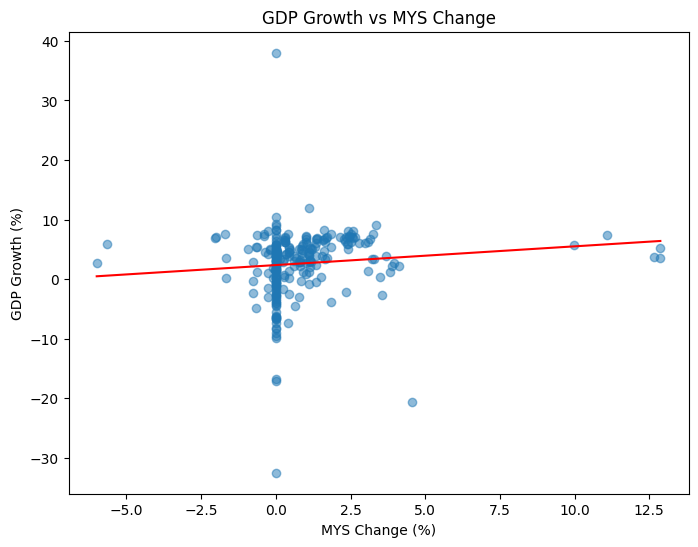

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# Load the merged dataset
df = pd.read_csv("/content/MYSchange_GDPgrowth_ADOonly.csv")

print(df.head())
print(df.describe())

# ===== Simple Linear Regression =====
X = sm.add_constant(df["MYS_change"])  # independent var: % change in Mean Years of Schooling
y = df["GDP_growth"]                   # dependent var: GDP growth %

model = sm.OLS(y, X).fit()
print(model.summary())

# ===== Optional: Scatter plot =====
plt.figure(figsize=(8,6))
plt.scatter(df["MYS_change"], df["GDP_growth"], alpha=0.5)
x_vals = np.linspace(df["MYS_change"].min(), df["MYS_change"].max(), 100)
plt.plot(x_vals, model.params.const + model.params.MYS_change*x_vals, color='red')
plt.xlabel("MYS Change (%)")
plt.ylabel("GDP Growth (%)")
plt.title("GDP Growth vs MYS Change")
plt.show()


In [ ]:
import pandas as pd
import re

# --------------------------
# 1) Paths
# --------------------------
mys_path = "/content/Human Development Index - Full.csv"
gdp_path = "/content/ADO April 2023 - GDP Growth.csv"  # ✅ 최신판만 지정

# --------------------------
# 2) Load & reshape MYS (TOTAL only)
# --------------------------
mys_raw = pd.read_csv(mys_path)
mys_raw.columns = mys_raw.columns.str.strip()

# Pick columns: start with "Mean Years of Schooling (" but NOT contain female/male
mys_cols = [c for c in mys_raw.columns
            if c.startswith("Mean Years of Schooling (")
            and "female" not in c.lower()
            and "male" not in c.lower()]

if not mys_cols:
    raise ValueError("No total 'Mean Years of Schooling (YYYY)' columns found.")

keep_cols = ['ISO3', 'Country'] + mys_cols
mys = mys_raw[keep_cols].copy()

# Rename MYS columns to just the year number
rename_map = {c: int(re.search(r'\d{4}', c).group()) for c in mys_cols}
mys = mys.rename(columns=rename_map)

# Melt to long
mys_long = mys.melt(id_vars=['ISO3','Country'], var_name='Year', value_name='MYS')
mys_long['Year'] = pd.to_numeric(mys_long['Year'], errors='coerce')
mys_long = mys_long.dropna(subset=['Year','MYS']).sort_values(['ISO3','Year'])

# Calculate year-to-year percentage change
mys_long['MYS_change'] = mys_long.groupby('ISO3')['MYS'].pct_change(fill_method=None) * 100

# --------------------------
# 3) Load GDP (April 2023 only)
# --------------------------
import chardet
with open(gdp_path, 'rb') as raw:
    enc = chardet.detect(raw.read(100000))['encoding'] or 'cp1252'

gdp = pd.read_csv(gdp_path, encoding=enc)
gdp.columns = gdp.columns.str.strip()

# Expect: RegionalMember | Year | GDP growth | Country Code
if {'RegionalMember','Year','GDP growth','Country Code'}.issubset(gdp.columns):
    gdp = gdp[['Country Code','RegionalMember','Year','GDP growth']].rename(
        columns={'Country Code':'ISO3',
                 'RegionalMember':'GDP_Country',
                 'GDP growth':'GDP_growth'}
    )
else:
    raise ValueError(f"Unexpected columns: {list(gdp.columns)}")

gdp['Year'] = pd.to_numeric(gdp['Year'], errors='coerce')
gdp = gdp.dropna(subset=['ISO3','Year','GDP_growth'])

# --------------------------
# 4) Merge on ISO3 + Year
# --------------------------
merged = pd.merge(mys_long, gdp, on=['ISO3','Year'], how='inner')
merged = merged[['ISO3','Country','GDP_Country','Year','MYS','MYS_change','GDP_growth']]
merged = merged.dropna(subset=['MYS_change','GDP_growth']).sort_values(['ISO3','Year'])

# --------------------------
# 5) Save
# --------------------------
output = "/content/MYSchange_GDPgrowth_ADO2023.csv"
merged.to_csv(output, index=False)

print(f"✅ Saved: {output}")
print(f"Rows: {len(merged):,} | ISO3 count: {merged['ISO3'].nunique()} | Years: {merged['Year'].min()}–{merged['Year'].max()}")
print(merged.head(12))


✅ Saved: /content/MYSchange_GDPgrowth_ADO2023.csv
Rows: 165 | ISO3 count: 42 | Years: 2018–2021
   ISO3      Country  GDP_Country  Year        MYS  MYS_change  GDP_growth
0   AFG  Afghanistan  Afghanistan  2018   2.659189    3.816794         1.2
1   AFG  Afghanistan  Afghanistan  2019   2.756953    3.676471         3.9
2   AFG  Afghanistan  Afghanistan  2020   2.854718    3.546099        -2.4
3   AFG  Afghanistan  Afghanistan  2021   2.985070    4.566210       -20.7
4   ARM      Armenia      Armenia  2018  11.235160    0.425205         5.2
5   ARM      Armenia      Armenia  2019  11.282730    0.423405         7.6
6   ARM      Armenia      Armenia  2020  11.330300    0.421620        -7.2
7   ARM      Armenia      Armenia  2021  11.330300    0.000000         5.7
8   AZE   Azerbaijan   Azerbaijan  2018  10.541760   -0.026925         1.5
9   AZE   Azerbaijan   Azerbaijan  2019  10.542970    0.011471         2.5
10  AZE   Azerbaijan   Azerbaijan  2020  10.542970    0.000000        -4.3
11  

  ISO3      Country  GDP_Country  Year        MYS  MYS_change  GDP_growth
0  AFG  Afghanistan  Afghanistan  2018   2.659189    3.816794         1.2
1  AFG  Afghanistan  Afghanistan  2019   2.756953    3.676471         3.9
2  AFG  Afghanistan  Afghanistan  2020   2.854718    3.546099        -2.4
3  AFG  Afghanistan  Afghanistan  2021   2.985070    4.566210       -20.7
4  ARM      Armenia      Armenia  2018  11.235160    0.425205         5.2
              Year         MYS  MYS_change  GDP_growth
count   165.000000  165.000000  165.000000  165.000000
mean   2019.509091    8.825325    0.751460    1.793333
std       1.124116    2.757685    2.076687    6.735808
min    2018.000000    2.659189   -5.996237  -33.500000
25%    2019.000000    6.549980    0.000000   -0.900000
50%    2020.000000    8.969100    0.000000    2.900000
75%    2021.000000   11.333394    1.100982    5.600000
max    2021.000000   12.848290   12.872314   41.700000
                            OLS Regression Results           

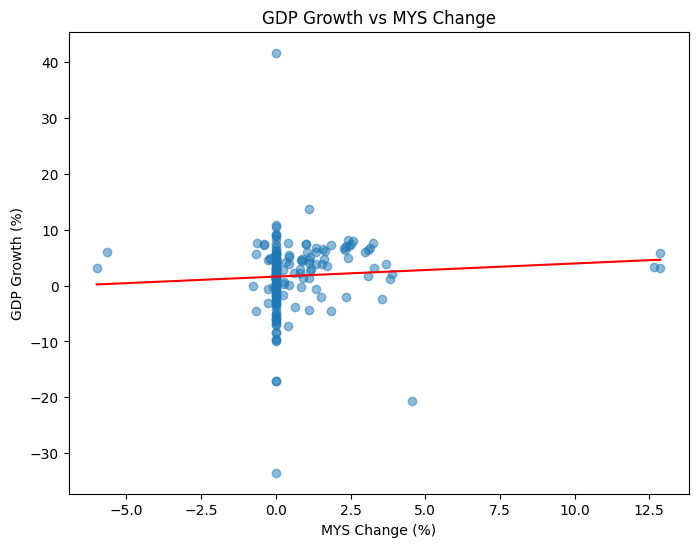

In [ ]:


# Load the merged dataset
df = pd.read_csv("/content/MYSchange_GDPgrowth_ADO2023.csv")

print(df.head())
print(df.describe())

# ===== Simple Linear Regression =====
X = sm.add_constant(df["MYS_change"])  # independent var: % change in Mean Years of Schooling
y = df["GDP_growth"]                   # dependent var: GDP growth %

model = sm.OLS(y, X).fit()
print(model.summary())

# ===== Optional: Scatter plot =====
plt.figure(figsize=(8,6))
plt.scatter(df["MYS_change"], df["GDP_growth"], alpha=0.5)
x_vals = np.linspace(df["MYS_change"].min(), df["MYS_change"].max(), 100)
plt.plot(x_vals, model.params.const + model.params.MYS_change*x_vals, color='red')
plt.xlabel("MYS Change (%)")
plt.ylabel("GDP Growth (%)")
plt.title("GDP Growth vs MYS Change")
plt.show()


In [ ]:
import pandas as pd

# ===============================
# 1. Load data
# ===============================
mys_file = "/content/Human Development Index - Full.csv"
gdp_file = "/content/gdp_per_capita_growth.csv"

mys = pd.read_csv(mys_file)
gdp = pd.read_csv(gdp_file)

# ===============================
# 2. Prepare MYS (Mean Years of Schooling)
# ===============================
mys_cols = [c for c in mys.columns if c.startswith("Mean Years of Schooling (")]
keep_cols = ["ISO3", "Country"] + mys_cols
mys = mys[keep_cols]

# Melt wide → long
mys_long = mys.melt(id_vars=["ISO3","Country"],
                    var_name="Year",
                    value_name="MYS")

# Extract year and convert to int
mys_long["Year"] = mys_long["Year"].str.extract(r"(\d{4})")
mys_long = mys_long.dropna(subset=["Year"])
mys_long["Year"] = mys_long["Year"].astype(int)

# Calculate year-to-year % change
mys_long = mys_long.sort_values(["ISO3","Year"])
mys_long["MYS_change"] = mys_long.groupby("ISO3")["MYS"].pct_change() * 100

# ===============================
# 3. Prepare GDP (World Bank wide → long)
# ===============================
gdp.columns = gdp.columns.str.strip()

gdp_long = gdp.melt(id_vars=["Country Name","Code"],
                    var_name="Year",
                    value_name="GDP_growth")

gdp_long["Year"] = pd.to_numeric(gdp_long["Year"], errors="coerce")
gdp_long = gdp_long.dropna(subset=["Year"])
gdp_long["Year"] = gdp_long["Year"].astype(int)

gdp_long.rename(columns={"Code":"ISO3", "Country Name":"GDP_Country"}, inplace=True)

# ===============================
# 4. Filter Asia + remove resource-dependent countries
# ===============================
asia_iso = [
    "AFG","ARM","AZE","BHR","BGD","BRN","BTN","KHM","CHN","HKG","MAC","GEO","IND","IDN","IRN","IRQ","ISR","JPN","JOR",
    "KAZ","KWT","KGZ","LAO","LBN","MYS","MDV","MNG","MMR","NPL","OMN","PAK","PHL","QAT","SAU","SGP","KOR","LKA","SYR",
    "TWN","TJK","THA","TLS","TUR","TKM","ARE","UZB","VNM","YEM","PNG","FJI","WSM","TON","VUT","PLW","FSM","MHL","KIR",
    "NRU","TUV"
]

exclude_iso = [
    "SAU","ARE","QAT","KWT","BHR","OMN","IRQ","IRN",
    "KAZ","TKM","AZE",
    "BRN","PNG","TLS"
]

asia_iso_clean = [x for x in asia_iso if x not in exclude_iso]

mys_long = mys_long[mys_long["ISO3"].isin(asia_iso_clean)]
gdp_long = gdp_long[gdp_long["ISO3"].isin(asia_iso_clean)]

# ===============================
# 5. Merge
# ===============================
merged = pd.merge(gdp_long, mys_long, on=["ISO3","Year"], how="inner")

merged = merged[["ISO3","Country","GDP_Country","Year","MYS","MYS_change","GDP_growth"]]

# ===============================
# 6. Save
# ===============================
merged.to_csv("/content/MYSchange_GDPpcgrowth_AsiaNoResource.csv", index=False)
print(f"✅ Saved: /content/MYSchange_GDPpcgrowth_AsiaNoResource.csv ({merged.shape[0]} rows)")
print(merged.head())
print(merged.describe())


✅ Saved: /content/MYSchange_GDPpcgrowth_AsiaNoResource.csv (1333 rows)
  ISO3      Country  GDP_Country  Year       MYS  MYS_change  GDP_growth
0  AFG  Afghanistan  Afghanistan  1990  0.971125         NaN         NaN
1  ARM      Armenia      Armenia  1990  9.781760         NaN         NaN
2  BGD   Bangladesh   Bangladesh  1990  3.294752         NaN    3.086982
3  BTN       Bhutan       Bhutan  1990       NaN         NaN    8.588876
4  CHN        China        China  1990  4.143790         NaN    2.406559
              Year          MYS   MYS_change   GDP_growth
count  1333.000000  1191.000000  1149.000000  1272.000000
mean   2005.000000     7.689135     1.849173     2.534273
std       8.947629     3.197654     2.607246     5.880773
min    1990.000000     0.290000   -10.000000   -45.325107
25%    1997.000000     4.860425     0.526691     0.492462
50%    2005.000000     7.875070     1.249254     3.163793
75%    2013.000000    10.485761     2.610966     5.503201
max    2020.000000    13.36

/tmp/ipython-input-3296382982.py:31: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  mys_long["MYS_change"] = mys_long.groupby("ISO3")["MYS"].pct_change() * 100


In [ ]:
import pandas as pd

# ===============================
# 1. Load data
# ===============================
mys_file = "/content/Human Development Index - Full.csv"
gdp_file = "/content/gdp_per_capita_growth.csv"

mys = pd.read_csv(mys_file)
gdp = pd.read_csv(gdp_file)

# ===============================
# 2. Prepare MYS (Mean Years of Schooling)
# ===============================
mys_cols = [c for c in mys.columns if c.startswith("Mean Years of Schooling (")]
keep_cols = ["ISO3", "Country"] + mys_cols
mys = mys[keep_cols]

# Melt wide → long
mys_long = mys.melt(id_vars=["ISO3","Country"],
                    var_name="Year",
                    value_name="MYS")

# Extract year and convert to int
mys_long["Year"] = mys_long["Year"].str.extract(r"(\d{4})")
mys_long = mys_long.dropna(subset=["Year"])
mys_long["Year"] = mys_long["Year"].astype(int)

# ===============================
# 3. Prepare GDP (World Bank wide → long)
# ===============================
gdp.columns = gdp.columns.str.strip()

gdp_long = gdp.melt(id_vars=["Country Name","Code"],
                    var_name="Year",
                    value_name="GDP_growth")

gdp_long["Year"] = pd.to_numeric(gdp_long["Year"], errors="coerce")
gdp_long = gdp_long.dropna(subset=["Year"])
gdp_long["Year"] = gdp_long["Year"].astype(int)

gdp_long.rename(columns={"Code":"ISO3", "Country Name":"GDP_Country"}, inplace=True)

# ===============================
# 4. Filter Asia + remove resource-dependent countries
# ===============================
asia_iso = [
    "AFG","ARM","AZE","BHR","BGD","BRN","BTN","KHM","CHN","HKG","MAC","GEO","IND","IDN","IRN","IRQ","ISR","JPN","JOR",
    "KAZ","KWT","KGZ","LAO","LBN","MYS","MDV","MNG","MMR","NPL","OMN","PAK","PHL","QAT","SAU","SGP","KOR","LKA","SYR",
    "TWN","TJK","THA","TLS","TUR","TKM","ARE","UZB","VNM","YEM","PNG","FJI","WSM","TON","VUT","PLW","FSM","MHL","KIR",
    "NRU","TUV"
]

exclude_iso = [
    "SAU","ARE","QAT","KWT","BHR","OMN","IRQ","IRN",
    "KAZ","TKM","AZE",
    "BRN","PNG","TLS"
]

asia_iso_clean = [x for x in asia_iso if x not in exclude_iso]

mys_long = mys_long[mys_long["ISO3"].isin(asia_iso_clean)]
gdp_long = gdp_long[gdp_long["ISO3"].isin(asia_iso_clean)]

# ===============================
# 5. Merge
# ===============================
merged = pd.merge(gdp_long, mys_long, on=["ISO3","Year"], how="inner")

merged = merged[["ISO3","Country","GDP_Country","Year","MYS","GDP_growth"]]

# ===============================
# 6. Save
# ===============================
merged.to_csv("/content/MYSlevel_GDPpcgrowth_AsiaNoResource.csv", index=False)
print(f"✅ Saved: /content/MYSlevel_GDPpcgrowth_AsiaNoResource.csv ({merged.shape[0]} rows)")
print(merged.head())
print(merged.describe())


✅ Saved: /content/MYSlevel_GDPpcgrowth_AsiaNoResource.csv (1333 rows)
  ISO3      Country  GDP_Country  Year       MYS  GDP_growth
0  AFG  Afghanistan  Afghanistan  1990  0.971125         NaN
1  ARM      Armenia      Armenia  1990  9.781760         NaN
2  BGD   Bangladesh   Bangladesh  1990  3.294752    3.086982
3  BTN       Bhutan       Bhutan  1990       NaN    8.588876
4  CHN        China        China  1990  4.143790    2.406559
              Year          MYS   GDP_growth
count  1333.000000  1191.000000  1272.000000
mean   2005.000000     7.689135     2.534273
std       8.947629     3.197654     5.880773
min    1990.000000     0.290000   -45.325107
25%    1997.000000     4.860425     0.492462
50%    2005.000000     7.875070     3.163793
75%    2013.000000    10.485761     5.503201
max    2020.000000    13.366100    43.377413


                            OLS Regression Results                            
Dep. Variable:             GDP_growth   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     7.181
Date:                Tue, 07 Oct 2025   Prob (F-statistic):            0.00748
Time:                        09:12:50   Log-Likelihood:                -3436.2
No. Observations:                1111   AIC:                             6876.
Df Residuals:                    1109   BIC:                             6886.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3025      0.197     11.708      0.0

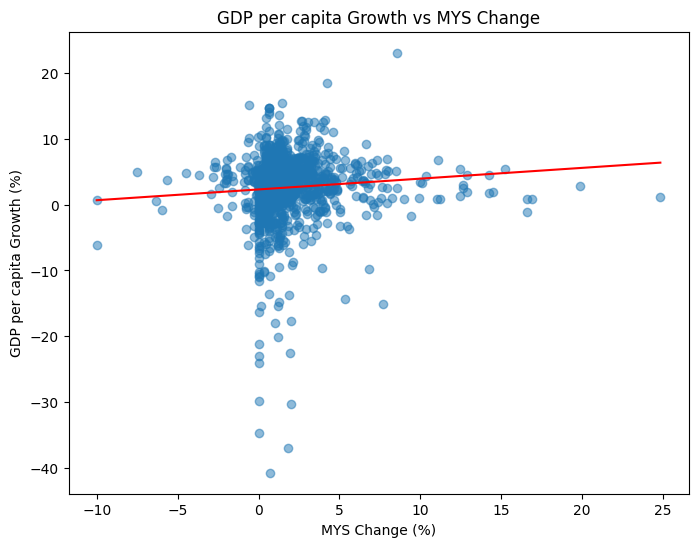

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np


df_reg = df_change.dropna(subset=["MYS_change", "GDP_growth"])

X = sm.add_constant(df_reg["MYS_change"])
y = df_reg["GDP_growth"]

model_change = sm.OLS(y, X).fit()
print(model_change.summary())


plt.figure(figsize=(8,6))
plt.scatter(df_reg["MYS_change"], df_reg["GDP_growth"], alpha=0.5)
x_vals = np.linspace(df_reg["MYS_change"].min(), df_reg["MYS_change"].max(), 100)
plt.plot(x_vals, model_change.params.const + model_change.params.MYS_change*x_vals, color='red')
plt.xlabel("MYS Change (%)")
plt.ylabel("GDP per capita Growth (%)")
plt.title("GDP per capita Growth vs MYS Change")
plt.show()




                            OLS Regression Results                            
Dep. Variable:             GDP_growth   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     6.679
Date:                Tue, 07 Oct 2025   Prob (F-statistic):            0.00988
Time:                        09:13:28   Log-Likelihood:                -3533.3
No. Observations:                1145   AIC:                             7071.
Df Residuals:                    1143   BIC:                             7081.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6206      0.420      8.621      0.0

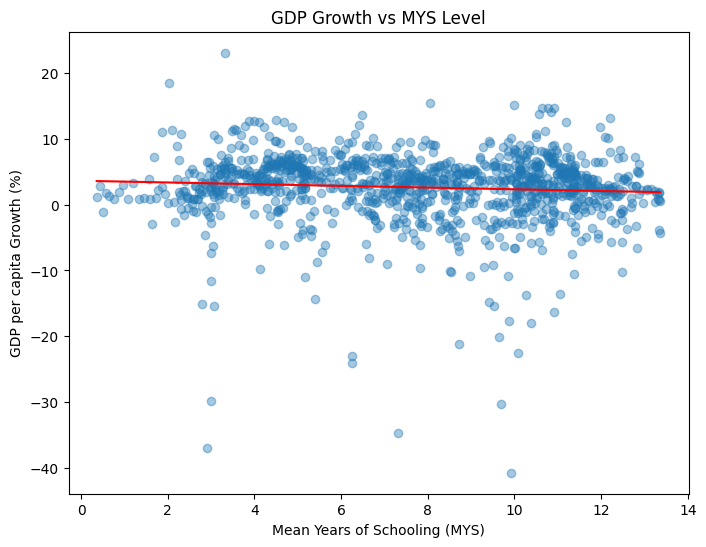

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv("/content/MYSlevel_GDPpcgrowth_AsiaNoResource.csv")

df_reg = df.dropna(subset=["MYS", "GDP_growth"])

X = sm.add_constant(df_reg["MYS"])
y = df_reg["GDP_growth"]


model = sm.OLS(y, X).fit()
print(model.summary())


plt.figure(figsize=(8,6))
plt.scatter(df_reg["MYS"], df_reg["GDP_growth"], alpha=0.4)
x_vals = np.linspace(df_reg["MYS"].min(), df_reg["MYS"].max(), 100)
plt.plot(x_vals, model.params.const + model.params.MYS * x_vals, color='red')
plt.xlabel("Mean Years of Schooling (MYS)")
plt.ylabel("GDP per capita Growth (%)")
plt.title("GDP Growth vs MYS Level")
plt.show()
